In [ ]:
from IPython.display import display, HTML
import ipywidgets as widgets
from ipywidgets import interact
# display(HTML("<style>.container { width:50% !important; height:10% !important; }</style>"))
display(HTML("<style>.container { width:75% !important; }</style>"))


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Preprocessing

## Parameters

In [3]:
# parameters

_round_num = 2
_symbol = "COCONUTS"
# _day_ind = -2
_day_range = [-1, 0, 1]
_book_range = list(range(1, 3+1))
_max_time = 1000000
_time_step = 100

In [4]:
def get_file_trades(day):
    fname = f"../data/round{_round_num}/trades_round_{_round_num}_day_{day}_nn.csv"
    print("fname", fname)
    return pd.read_csv(fname, sep=";")


def get_file_prices(day):
    fname = f"../data/round{_round_num}/prices_round_{_round_num}_day_{day}.csv"
    print("fname", fname)
    return pd.read_csv(fname, sep=";")

## read data

In [5]:
# get data for each day
trades = []
prices = []

for day in _day_range:
    # get data from files
    trade_df = get_file_trades(day)
    price_df = get_file_prices(day)
    
    trade_df["day"] = day
    
    trades += [trade_df]
    prices += [price_df]

# concat all data
trade_df = pd.concat(trades)
price_df = pd.concat(prices)

# reset indexes
trade_df = trade_df.reset_index(drop=True)
price_df = price_df.reset_index(drop=True)


# print columns that we believe to be irrelevant
# currency - SEASHELLS only
# buyer - nan only
# seller - nan only
display(trade_df["currency"].value_counts())
display(trade_df["buyer"].value_counts())
display(trade_df["seller"].value_counts())

# drop irrelevant columns
trade_df = trade_df.drop(["currency", "buyer", "seller"], axis=1)

# rename columns
price_df = price_df.rename({"product": "symbol"}, axis=1)
price_df = price_df.rename({"timestamp": "time"}, axis=1)

trade_df = trade_df.rename({"timestamp": "time"}, axis=1)

# filter for specific symbol
trade_df = trade_df[trade_df["symbol"] == _symbol]
price_df = price_df[price_df["symbol"] == _symbol]

# calculate new time (for multiday)
trade_df["time"] = trade_df["time"] + (trade_df["day"] - min(_day_range)) * _max_time
price_df["time"] = price_df["time"] + (price_df["day"] - min(_day_range)) * _max_time

# rename "bid" to "buy"
# rename "ask" to "sell"
price_df = price_df.rename({col: col.replace("bid", "buy") for col in price_df.columns if "bid" in col}, axis=1)
price_df = price_df.rename({col: col.replace("ask", "sell") for col in price_df.columns if "ask" in col}, axis=1)


fname ../data/round2/trades_round_2_day_-1_nn.csv
fname ../data/round2/prices_round_2_day_-1.csv
fname ../data/round2/trades_round_2_day_0_nn.csv
fname ../data/round2/prices_round_2_day_0.csv
fname ../data/round2/trades_round_2_day_1_nn.csv
fname ../data/round2/prices_round_2_day_1.csv


SEASHELLS    17815
Name: currency, dtype: int64

Series([], Name: buyer, dtype: int64)

Series([], Name: seller, dtype: int64)

In [6]:
# clean unreasonable data

print("price min/max", trade_df["price"].min(), trade_df["price"].max())
print("quantity min/max", trade_df["quantity"].min(), trade_df["quantity"].max())

if _symbol == "BANANAS":
    display(trade_df[trade_df["price"] < 4500])
    display(trade_df[trade_df["price"] > 5500])

    trade_df = trade_df[trade_df["price"] >= 4500]
    trade_df = trade_df[trade_df["price"] <= 5500]



price min/max 7866.0 8116.0
quantity min/max 1 79


# Large Quotes

## calculate large quote data

In [7]:
def get_book_large_size(side):
    """ 
    side = 'buy' or 'sell' 
    
    Returns prices, sizes
    """
    
    book_range = list(range(1, 3+1))
    
    # get bids
    bid_sizes = price_df[[f"{side}_volume_{i}" for i in book_range]]
    bid_prices = price_df[[f"{side}_price_{i}" for i in book_range]]

    # replace nan with -1
    bid_sizes = bid_sizes.replace(np.nan, -1)

    # find inds
    inds = np.argmax(bid_sizes.to_numpy(), axis=1)

    # filter to keep largest bids
    bid_prices = bid_prices.to_numpy()[np.arange(len(bid_prices)), inds]
    bid_sizes = bid_sizes.to_numpy()[np.arange(len(bid_sizes)), inds]
    
    # create dataframe
    df = pd.DataFrame([bid_prices, bid_sizes]).T
    df.columns = [f"{side}_price", f"{side}_size"]
    df["time"] = price_df["time"].reset_index()["time"]
    
    return df

In [8]:
# get big buy/sell quotes
buy_df = get_book_large_size("buy")
sell_df = get_book_large_size("sell")

# create big quote_df
quote_df = pd.merge(buy_df, sell_df, on="time")
quote_df["mid_price"] = (quote_df["buy_price"] + quote_df["sell_price"]) / 2
quote_df["spread"] = quote_df["sell_price"] - quote_df["buy_price"]

# edge is calculated from perspective of buyer
trade_df = trade_df.merge(quote_df[["time", "mid_price"]], on="time")
trade_df["edge"] = trade_df["mid_price"] - trade_df["price"]

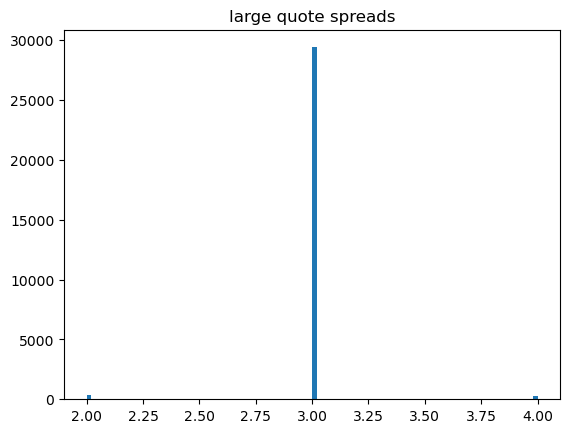

,index,spread
0,3.0,29391
1,2.0,361
2,4.0,248


In [9]:
plt.hist(quote_df["spread"], bins=100)
plt.title("large quote spreads")
plt.show()

display(quote_df["spread"].value_counts().reset_index())

## whale quote: order over time

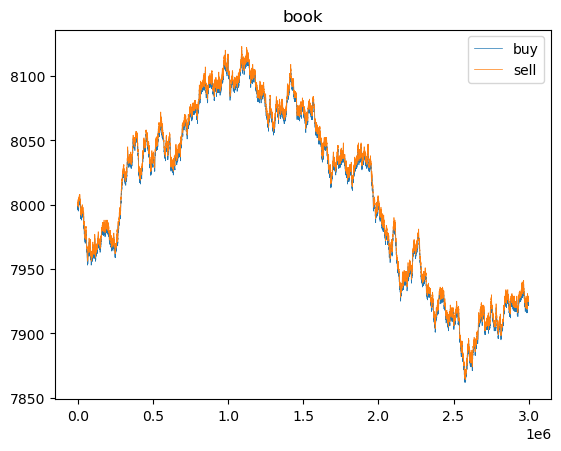

In [10]:
# lb, ub = 2e6, 2e6+1e5
# quote_df = quote_df[lb <= quote_df["time"]]
# quote_df = quote_df[quote_df["time"] <= ub]

plt.plot(quote_df["time"], quote_df["buy_price"], linewidth=0.5, label="buy")
plt.plot(quote_df["time"], quote_df["sell_price"], linewidth=0.5, label="sell")
plt.title("book")
plt.legend()

## whale quote: sizing histogram

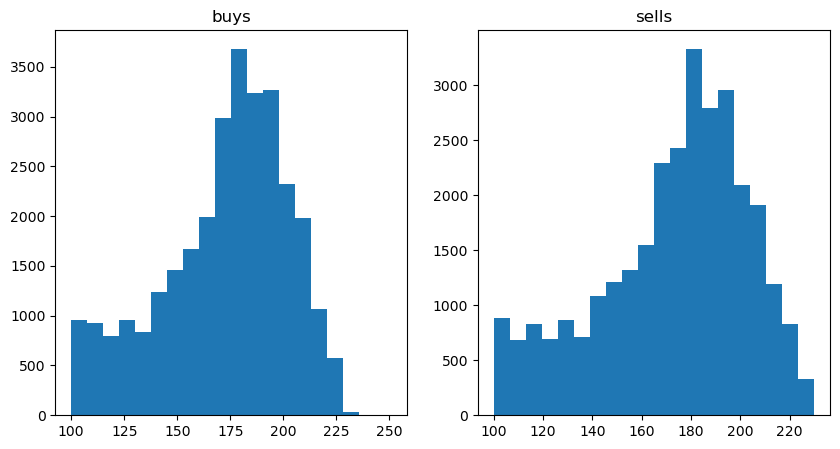

,index,buy_size
0,181.0,502
1,184.0,493
2,191.0,482
3,183.0,476
4,182.0,473
...,...,...
131,237.0,1
132,244.0,1
133,251.0,1
134,247.0,1


,index,sell_size
0,184.0,502
1,182.0,496
2,180.0,491
3,179.0,479
4,190.0,477
...,...,...
126,226.0,55
127,227.0,48
128,228.0,45
129,229.0,23


In [11]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.hist(quote_df["buy_size"], bins=20)
plt.title("buys")

plt.subplot(122)
plt.hist(quote_df["sell_size"], bins=20)
plt.title("sells")

plt.show()


display(quote_df["buy_size"].value_counts().reset_index())
display(quote_df["sell_size"].value_counts().reset_index())

## whale quote: mid_price change stats

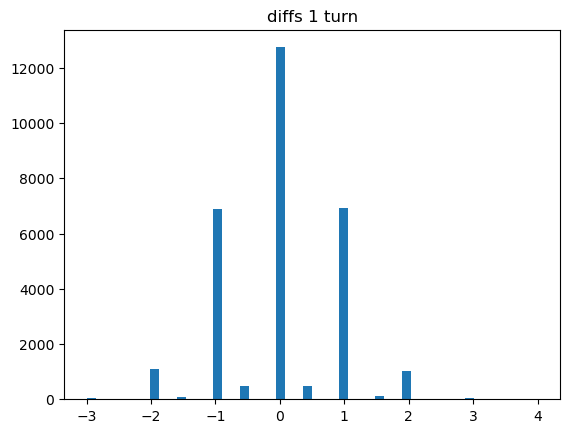

,count,mean,std,min,25%,50%,75%,max
mid_price,29999.0,-0.002567,0.897448,-3.0,-1.0,0.0,1.0,4.0


std size 155.44004559268384
total change -77.0
z-score -0.495367842349785


In [12]:
# diffs
diffs = quote_df["mid_price"] - quote_df["mid_price"].shift(1)
diffs = diffs.dropna()

_ = plt.hist(diffs, bins=50)
plt.title("diffs 1 turn")
plt.show()


diff_desc = pd.DataFrame(diffs).describe().T
display(diff_desc)

stdev = np.sqrt(len(diffs))* diff_desc["std"].iloc[0]
print("std size", stdev)
print("total change", diffs.sum())
print("z-score", diffs.sum() / stdev)

## linreg on large quote mid price

In [13]:
from sklearn.linear_model import LinearRegression

In [14]:
_turn_diffs = [-1, -10]
_pred_diff = 10

data = []

# get input data
for diff in _turn_diffs:
    data += [quote_df["mid_price"] - quote_df["mid_price"].shift(-1 * diff)]

# get output data
data += [quote_df["mid_price"].shift(-1 * _pred_diff) - quote_df["mid_price"]]

# form X, y - clean data
X = pd.concat(data, axis=1)
X = X.dropna()
X.columns = [f"d_{diff}" for diff in [*_turn_diffs, _pred_diff]]

y = X[[f"d_{_pred_diff}"]]
X = X.drop(f"d_{_pred_diff}", axis=1)

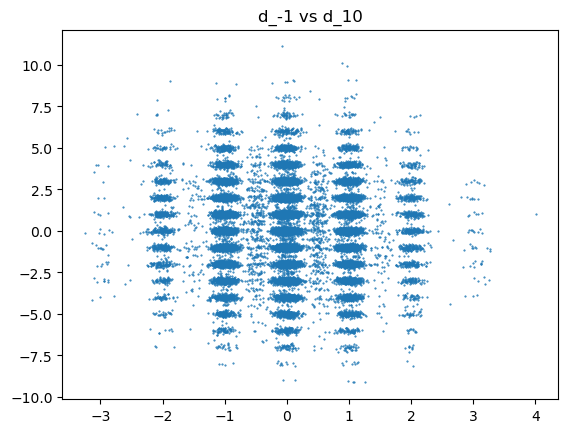

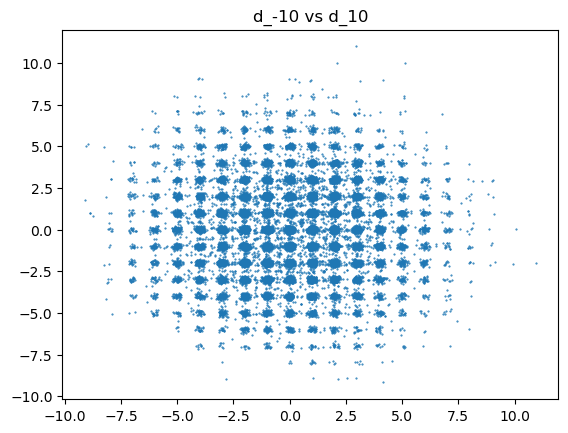

In [15]:
for col in X.columns:
    Xp = X[col] + np.random.normal(scale=0.1, size=X[col].shape)
    yp = y + np.random.normal(scale=0.1, size=y.shape)
    plt.scatter(Xp, yp, s=0.25)
    plt.title(col + " vs " + y.columns[0])
    plt.show()

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-9. , -8.6, -8.2, -7.8, -7.4, -7. , -6.6, -6.2, -5.8, -5.4, -5. ,
        -4.6, -4.2, -3.8, -3.4, -3. , -2.6, -2.2, -1.8, -1.4, -1. , -0.6,
        -0.2,  0.2,  0.6,  1. ,  1.4,  1.8,  2.2,  2.6,  3. ,  3.4,  3.8,
         4.2,  4.6,  5. ,  5.4,  5.8,  6.2,  6.6,  7. ,  7.4,  7.8,  8.2,
         8.6,  9. ,  9.4,  9.8, 10.2, 10.6, 11. ]),
 array([-9. , -8.6, -8.2, -7.8, -7.4, -7. , -6.6, -6.2, -5.8, -5.4, -5. ,
        -4.6, -4.2, -3.8, -3.4, -3. , -2.6, -2.2, -1.8, -1.4, -1. , -0.6,
        -0.2,  0.2,  0.6,  1. ,  1.4,  1.8,  2.2,  2.6,  3. ,  3.4,  3.8,
         4.2,  4.6,  5. ,  5.4,  5.8,  6.2,  6.6,  7. ,  7.4,  7.8,  8.2,
         8.6,  9. ,  9.4,  9.8, 10.2, 10.6, 11. ]),
 <matplotlib.collections.QuadMesh at 0x11db307c0>)

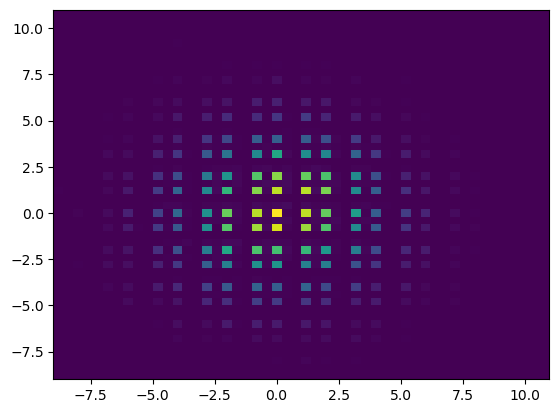

In [16]:
plt.hist2d(X[col], y[y.columns[0]], bins=50)

,count,mean,std,min,25%,50%,75%,max
d_10,29980.0,-0.025267,2.59204,-9.0,-2.0,0.0,2.0,11.0


,count,mean,std,min,25%,50%,75%,max
d_10,29980.0,2.056154,1.578417,0.0,1.0,2.0,3.0,11.0


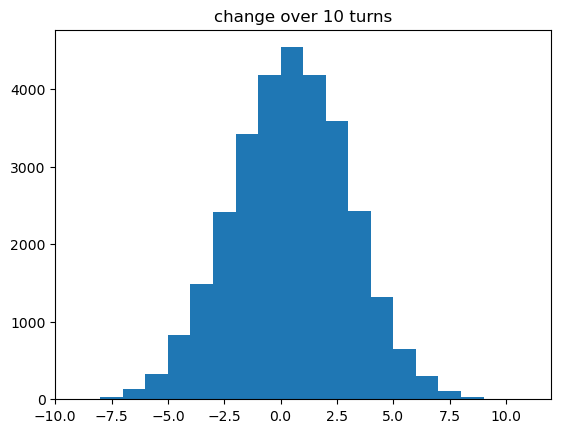

In [17]:
plt.title(f"change over {_pred_diff} turns")
plt.hist(y, bins=20)

display(y.describe().T)
display(abs(y).describe().T)


In [18]:
reg = LinearRegression().fit(X, y)
display(reg.coef_)
display(reg.intercept_)

array([[-0.10062683,  0.01535994]])

array([-0.02513371])

In [19]:
print("coeffs", sum(reg.coef_))
print("intercept", sum(reg.intercept_))
print("score", reg.score(X, y))

coeffs [-0.10062683  0.01535994]
intercept -0.02513370736192416
score 0.0011104461158043533


In [20]:
error = reg.predict(X) - y
error["abs"] = abs(error[f"d_{_pred_diff}"])

error.describe().T

,count,mean,std,min,25%,50%,75%,max
d_10,29980.0,1.896045e-18,2.590601,-10.979054,-1.970587,-0.025134,1.928786,9.020946
abs,29980.0,2.064593e+00,1.564777,0.001307,0.963694,1.944146,3.005586,10.979054


In [21]:
pd.DataFrame(reg.predict(X)).describe().T

,count,mean,std,min,25%,50%,75%,max
0,29980.0,-0.025267,0.086375,-0.366201,-0.086573,-0.025134,0.029413,0.307467


# Postbook

## postbook helper methods

In [22]:
def get_postbook_bounds(time, interval):
    
    # get nearest 100k
    
    lb = (time // interval) * interval
    ub = lb + interval
        
    # filter data to only use interval
    ts = trade_df[(lb < trade_df["time"]) & (trade_df["time"] < ub)]
    ps = price_df[(lb < price_df["time"]) & (price_df["time"] < ub)]
    

    # calc min/max prices
    min_prices = []
    max_prices = []

    for i in _book_range:
        prices = ps[f"buy_price_{i}"]
        min_prices += [prices.min()]
        max_prices += [prices.max()]

    for i in _book_range:
        prices = ps[f"sell_price_{i}"]
        min_prices += [prices.min()]
        max_prices += [prices.max()]

    prices = ts["price"]
    min_prices += [prices.min()]
    max_prices += [prices.max()]


    xmin = min(min_prices)
    xmax = max(max_prices)
    
    
    
    # calc min/max sizes
    
    max_sizes = []
    
    # include 
    for i in _book_range:
        sizes = ps[f"buy_volume_{i}"]
        max_sizes += [sizes.max()]
        
    for i in _book_range:
        sizes = ps[f"sell_volume_{i}"]
        max_sizes += [sizes.max()]
    
    # include trade sizes
    max_sizes += [trade_df["quantity"].max()]
    
    ymin = 0
    ymax = 1.1 * max(max_sizes)
    
    return xmin, xmax, ymin, ymax

In [23]:
def get_book(sym, time):
    cur_prices = price_df[price_df["time"] == time].iloc[0]
    
    buys = []

    for i in _book_range:
        price, size = cur_prices[f"buy_price_{i}"], cur_prices[f"buy_volume_{i}"]
        if np.isnan(price):
            continue
        buys += [{"price": price, "quantity": size}]

    sells = []

    for i in _book_range:
        price, size = cur_prices[f"sell_price_{i}"], cur_prices[f"sell_volume_{i}"]
        if np.isnan(price):
            continue
        sells += [{"price": price, "quantity": size}]
        
    buys = pd.DataFrame(buys, columns=["price", "quantity"])
    sells = pd.DataFrame(sells, columns=["price", "quantity"])
    
    empty = pd.DataFrame([], columns=["price", "quantity"])

    return buys, sells, empty, empty


def get_trades(sym, time):
    
#     market_ts = trade_df[(trade_df["symbol"] == sym) & (trade_df["time"] == time)]
    market_ts = trade_df[trade_df["time"] == time]
    
    market_ts = market_ts.groupby(["symbol", "time", "price"])[["quantity"]].sum().reset_index()
#     my_ts = my_ts.groupby(["symbol", "time", "price", "my_buy", "my_sell"])[["quantity"]].sum().reset_index()
    
    return market_ts, pd.DataFrame([], columns=market_ts.columns)
    

def show_book(sym, 
              time, 
              xmin=None, 
              xmax=None,
              ymin=None, 
              ymax=None,
             ):
        
    # set figsize    
    plt.figure(figsize=(15,6))
    
    buys, sells, my_buys, my_sells = get_book(sym, time)
    market_ts, my_ts = get_trades(sym, time + _time_step)

    
    # make bars have correct sign
#     sells["quantity"] *= -1
#     my_buys["quantity"] *= -1
#     my_ts["quantity"] *= -1
    
    # plot order book
    if len(buys) > 0:
        plt.bar(buys["price"], buys["quantity"], color="green", label="market buy")
    if len(sells) > 0:
        plt.bar(sells["price"], sells["quantity"], color="red", label="market sells")
    
    if len(my_buys) > 0:
        plt.bar(my_buys["price"], my_buys["quantity"], color="blue", label="my buy")
    if len(my_sells) > 0:
        plt.bar(my_sells["price"], my_sells["quantity"], color="orange", label="my sell")
    
    # plot trades
    if len(market_ts) > 0:
        plt.bar(market_ts["price"], market_ts["quantity"], color=(0, 0, 0, 0), label="market trade", 
                hatch="///", edgecolor="black")
        
    if len(my_ts) > 0:
        plt.bar(my_ts["price"], my_ts["quantity"], color=(0, 0, 0, 0), label="my trade",
                hatch="xxx", edgecolor="black")
    
    # use log scale
    plt.yscale('symlog')
    
    
    ### draw reference lines
    
    # set xlim, ylim
    if xmin:
        plt.xlim(xmin=xmin)
    if xmax:
        plt.xlim(xmax=xmax)
    if ymin:
        plt.ylim(bottom=ymin)
    if ymax:
        plt.ylim(top=ymax)
    
    # draw horizontal line at 0 
    plt.axhline(y=0.0, color="black", linestyle='-')
    
    # draw true mid
    if len(buys) > 0 and len(sells) > 0:
        true_mid = (buys["price"][0] + sells["price"][0]) / 2
        plt.axvline(x=true_mid, color="red", linestyle='solid', alpha=0.2)
    
    # draw ref ema
    ref_ema = quote_df[quote_df["time"] == time]["mid_price"].iloc[0]
    plt.axvline(x=ref_ema, color="black", linestyle='dotted')
    
#     ema_span = raw_records[raw_records["time"] == time]["best_ema_spans"].iloc[0][sym]
    
    ### general figure settings    
    plt.legend(loc="upper center")
    plt.title(f"{sym} book - Time: {time}")
#     plt.title(f"{sym} book - Time: {time} - ema_span: {ema_span}")
    plt.show()
    
    
    ### print raw info
#     print("ref_ema", ref_ema)
    
    print("market trades")
    display(market_ts)
    print("my trades")
    display(my_ts)
    
    print("buys")
    display(buys.T)
    print("sells")
    display(sells.T)
    print("my_buys")
    display(my_buys.T)
    print("my_sells")
    display(my_sells.T)
    
def show_book_simple(
        sym,
        time=0,
        bound_interval=10000,
        # ymin=None,
        # ymax=None,
        ):
    
    xmin, xmax, ymin, ymax = get_postbook_bounds(time, bound_interval)
    
    show_book(
        sym, 
        time,
        xmin=xmin - 1,
        xmax=xmax + 1,
        ymin=-1,
        ymax=ymax,
    )

## Postbook reconstruction

In [24]:

interact(
    show_book_simple,
    sym=["BANANAS", "PEARLS", "PINA_COLADAS", "COCONUTS"],
    time=(0, len(_day_range) * _max_time, _time_step),
    bound_interval=10000,
)

interactive(children=(Dropdown(description='sym', options=('BANANAS', 'PEARLS', 'PINA_COLADAS', 'COCONUTS'), v…

<function __main__.show_book_simple(sym, time=0, bound_interval=10000)>

In [25]:
# filter between our times
# trade_df = trade_df[(2e6 <= trade_df["time"]) & (trade_df["time"] < 2e6 + 1e5)]
# price_df = price_df[(2e6 <= price_df["time"]) & (price_df["time"] < 2e6 + 1e5)]


## Best Taker Analysis

In [26]:
# get all buy_order_df
buy_data = [price_df[[f"buy_price_{i}", f"buy_volume_{i}", "time"]] for i in _book_range]
buy_data = [df.set_axis(labels=["price", "quantity", "time"], axis=1) for df in buy_data]
buy_df = pd.concat(buy_data).dropna()
buy_df = buy_df.sort_values(by="time").reset_index(drop=True)

# get all sell_order_df
sell_data = [price_df[[f"sell_price_{i}", f"sell_volume_{i}", "time"]] for i in _book_range]
sell_data = [df.set_axis(labels=["price", "quantity", "time"], axis=1) for df in sell_data]
sell_df = pd.concat(sell_data).dropna()
sell_df = sell_df.sort_values(by="time").reset_index(drop=True)

# negate quantity for sells
sell_df["quantity"] *= -1

In [27]:
# combine buy_df/sell_df into order_df
order_df = pd.concat([buy_df, sell_df]) \
                .sort_values(by=["time", "price"], ascending=True) \
                .reset_index(drop=True)

# merge mid_price (of large quotes) into order_df
order_df = order_df.merge(quote_df[["time", "mid_price"]], on="time")

# calculate edge if this order goes through
order_df["edge"] = np.sign(order_df["quantity"]) * (order_df["mid_price"] - order_df["price"])


In [28]:
# find orders with negative edge for maker (taker wins)
taker_df = order_df[order_df["edge"] <= 0].copy()

taker_df["edge"] = -1 * taker_df["edge"]

taker_df["abs_quantity"] = taker_df["quantity"].abs()
taker_df["pnl"] = taker_df["edge"] * taker_df["abs_quantity"]


In [29]:
# calculate total potential taker profit
print("take edge total", taker_df["pnl"].sum())

take edge total 37843.5


,abs_quantity
edge,
0.0,2105.0
0.5,75619.0
1.0,34.0


Text(0.5, 1.0, 'Edge distribution of profitable takes')

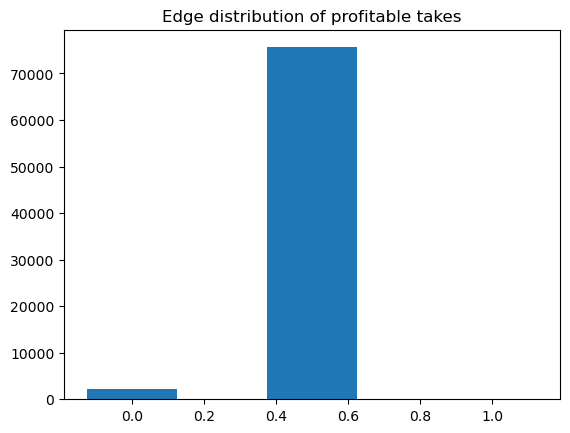

In [30]:
# show distribution of edge (by volume)

take_stats = taker_df.groupby("edge")[["abs_quantity"]].sum()
display(take_stats)

plt.bar(abs(take_stats.index), take_stats["abs_quantity"], width=0.25)
plt.title("Edge distribution of profitable takes")


## Best maker analysis

In [31]:
# print total maker volume over sample time
sample_size = trade_df[(trade_df["time"] > 2e6) & (trade_df["time"] < 2e6 + 1e5)][["quantity"]].abs().sum()
print("Sample - total edge volume", sample_size.item())

Sample - total edge volume 928


In [32]:
# show total maker profit
maker_df = trade_df.copy()

maker_df["edge"] = maker_df["edge"].abs()
maker_df["quantity"] = maker_df["quantity"].abs() # is already pos, does nothing

maker_df["pnl"] = maker_df["edge"] * maker_df["quantity"]

edge,0.5,1.0,1.5
quantity,19596,478,5657


<BarContainer object of 3 artists>

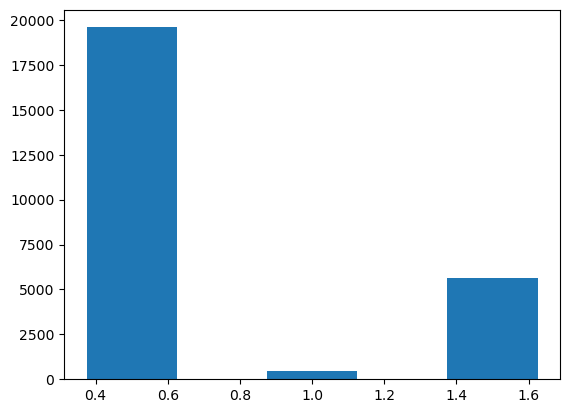

In [33]:
maker_stats = maker_df.groupby("edge")[["quantity"]].sum()
display(maker_stats.T)

plt.bar(maker_stats.index, maker_stats["quantity"], width=0.25)

## Maker/taker stats summary

In [34]:
_factor = 1 / 30

print(f"Symbol: {_symbol}")

print("Total Maker Edge", maker_df["pnl"].sum())
print("Total Potential Taker Edge", taker_df["pnl"].sum())

print("Maker edge (scaled)", maker_df["pnl"].sum() * _factor)
print("Taker edge (scaled)", taker_df["pnl"].sum() * _factor)


Symbol: COCONUTS
Total Maker Edge 18761.5
Total Potential Taker Edge 37843.5
Maker edge (scaled) 625.3833333333333
Taker edge (scaled) 1261.45


In [35]:
num_turns = len(_day_range) * _max_time / _time_step
print("num turns", num_turns)
print("take ratio", len(taker_df) / num_turns)
print("make ratio", len(maker_df) / num_turns)



num turns 30000.0
take ratio 0.0512
make ratio 0.03593333333333333
